# Predicting Potential Strokes

Group Members: Maxwell Arena, Nathan Poteet, Sanjay Srikumar, Akshay Shivkumar

# Why is it important to predict strokes?
Strokes are the 4th health related cause of death in the United States, trailing behind Heart Disease, Cancer, and Lower Respiratory Ilnesses. In 2019 alone, there were 150,005 deaths related to strokes. There is a lot of overlap between heart disease and strokes according to the CDC, and as they are all cardiovasular illnesses, which combined, account for 1/3 of all deaths in the United States. There are a number of ways that strokes affect the daily lives of people in this country, such as loss of major sensory function and reduced brain capacity. We see that dogs are fit to predict cancer in potential cancer patients given a blood sample to almost a 97% accuracy. 

Sources taken from statistics from the Center for Disease Control ([cdc.gov](https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm))

There is clear exigence behind the applications shown in this tutorial. By simply keeping track of a few statistics about patients, we are able to predict stroke with relatively high accuracy, as seen from the results below. This has significant implications within the medical community. With enough data, we may be able to predict, prevent, and treat diseases before patients have any severe symptoms. Furthermore, we could potentially predict other kinds of conditions that can afflict humans. The possible applications that could benefit medicine are endless.








# Outline
*   Clerical Work
*   Basic Analysis
*   Decision tree
*   Neural Network





# Preanalysis Clerical Work


First we want to import all the libraries that we need in this project, since there are a lot of data modeling and visualization libraries that we need, such as [tensorflow](https://www.tensorflow.org/api_docs/python/tf) and [sklearn](https://scikit-learn.org/stable/getting_started.html), as well as the general libraries that we have made heavy use out of, such as pandas, numpy, and matplotlib. We must ensure that they are all imported before calling them so as to not cause any errors.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from sklearn import model_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import statsmodels.formula.api as smf
import requests
from sklearn import svm, tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib import pyplot
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras
import seaborn as sns


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reading in the data
We want to read in the csv file and print out the first 10 rows of the dataframe so that we have a good idea of what the data is that we are working with, and what the column headers are so we have a good general idea of ways we may want to manipulate the data.

In [ ]:
original_df = pd.read_csv('./healthcare-dataset-stroke-data.csv')
original_df

id  gender   age  ...   bmi   smoking_status stroke
0      9046    Male  67.0  ...  36.6  formerly smoked      1
1     51676  Female  61.0  ...   NaN     never smoked      1
2     31112    Male  80.0  ...  32.5     never smoked      1
3     60182  Female  49.0  ...  34.4           smokes      1
4      1665  Female  79.0  ...  24.0     never smoked      1
...     ...     ...   ...  ...   ...              ...    ...
5105  18234  Female  80.0  ...   NaN     never smoked      0
5106  44873  Female  81.0  ...  40.0     never smoked      0
5107  19723  Female  35.0  ...  30.6     never smoked      0
5108  37544    Male  51.0  ...  25.6  formerly smoked      0
5109  44679  Female  44.0  ...  26.2          Unknown      0

[5110 rows x 12 columns]

In the above dataframe, we see 11 columns which are represented in a number of ways. One of the ways the makers of this dataset chose to store this data was to store 0 as not having that feature and 1 as having that feature. These columns are
- id number
- Gender
- Hypertension
- Heart Disease
- Ever Married
- Work Type
- Residence Type
- Average Glucose Level
- BMI
- Smoking Status
- Stroke

These are fairly self explanatory titles for the titles of the columns, so we don't need to tidy the column names any further.


# Tidying the data we do not need

There a number of columns that we do not need and therefore, we can drop from the dataframe to make it more readable. We will remove 'id' and 'stroke'. We want to remove 'id' because there is no reason for us to actually look at the id of a given study participant because we do not care for a piece of data that is relating to one's identity. We don't want to have the information relating to stroke because that is we are trying to predict with our models. We drop these two columns from our dataframe. We also want to disinclude any row that has null data values so as to not corrupt our data and yield false results. 

We do not need to group the data either because once we run our model, we are passing in the column names as the features to model off of, so the algorithm knows best what to do for it.


In [ ]:
# Drop the null and columns we do not want
df = original_df.copy().dropna() # Getting rid of rows with NaN
# This yields a dataframe that looks like this
df.head()


id  gender   age  ...   bmi   smoking_status stroke
0   9046    Male  67.0  ...  36.6  formerly smoked      1
2  31112    Male  80.0  ...  32.5     never smoked      1
3  60182  Female  49.0  ...  34.4           smokes      1
4   1665  Female  79.0  ...  24.0     never smoked      1
5  56669    Male  81.0  ...  29.0  formerly smoked      1

[5 rows x 12 columns]

# Making the data parseable
One potential issue that we were running into was that a lot of the data in the table was displayed qualitatively rather than quantitatively, which would have made it hard to run a model effectively. We took the data in the rows and columns and cast it to a numerical value using dictionaries so that whenever we come across a word such as 'Private' or 'Self-employed' when relating to the type of job that someone has, we can assign a number to it. We did this casting to all data that we came across that was displayed as words. The data that was displayed as numbers didn't need any manipulation as it was already possible to cast directly to a float.

We then use a loop and go through to reassign all the data that is kept as words to being numbers. We can see the result of these conversions below. 

In [ ]:
# Each dictionary is unique to a column of the dataframe that cannot be parsed numerically. 
# These dictionaries are a measure we took to ensure even non numerical data is measured numerically. 
empoyment_dict = {'Self-employed': 0, 'Private': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4}
gender_dict = {'Male': 0, 'Female': 1, 'Other': 2}
smoking_dict = {'never smoked': 0, 'formerly smoked': 1, 'Unknown': 2, 'smokes': 3}
life_dict = {'Urban': 0, 'Rural': 1}
married_dict = {'No': 0, 'Yes': 1}

for row in df.iterrows():
  df.at[row[0], 'work_type'] = empoyment_dict[row[1]['work_type']]
  df.at[row[0], 'gender'] = gender_dict[row[1]['gender']]
  df.at[row[0], 'smoking_status'] = smoking_dict[row[1]['smoking_status']]
  df.at[row[0], 'Residence_type'] = life_dict[row[1]['Residence_type']]
  df.at[row[0], 'ever_married'] = married_dict[row[1]['ever_married']]
df.head(n = 10)

id gender   age  ...   bmi  smoking_status stroke
0    9046      0  67.0  ...  36.6               1      1
2   31112      0  80.0  ...  32.5               0      1
3   60182      1  49.0  ...  34.4               3      1
4    1665      1  79.0  ...  24.0               0      1
5   56669      0  81.0  ...  29.0               1      1
6   53882      0  74.0  ...  27.4               0      1
7   10434      1  69.0  ...  22.8               0      1
9   60491      1  78.0  ...  24.2               2      1
10  12109      1  81.0  ...  29.7               0      1
11  12095      1  61.0  ...  36.8               3      1

[10 rows x 12 columns]

In [ ]:
encoded_data= df.drop(['stroke', 'id'], axis=1) #integer encoding
encoded_data['avg_glucose_level'] = (np.array(encoded_data['avg_glucose_level']) - np.mean(encoded_data['avg_glucose_level']))/max(encoded_data['avg_glucose_level'])
encoded_data['bmi'] = (np.array(encoded_data['bmi']) - np.mean(encoded_data['bmi']))/max(encoded_data['bmi'])
encoded_data['age'] = (np.array(encoded_data['age']) - np.mean(encoded_data['age']))/max(encoded_data['age'])
encoded_data['stroke'] = df['stroke']
correlations = encoded_data.corrwith(encoded_data["stroke"]) #correlation of variables in original df
print(correlations)


age                  0.232331
hypertension         0.142515
heart_disease        0.137938
avg_glucose_level    0.138936
bmi                  0.042374
stroke               1.000000
dtype: float64


# Exploratory Data Analysis
First and foremost, we want to better visualize the data so that we can know best how we want to model the strokes and under what classification and features we may want to look at when conducting the meat of our research. 



# Graphing Correlation Matrix between Variables

We wanted to see the correlation between any of the variables in our dataframe and others so we went with a [correlation matrix](https://www.displayr.com/what-is-a-correlation-matrix/#:~:text=A%20correlation%20matrix%20is%20a,a%20diagnostic%20for%20advanced%20analyses.). Obviously, we want to use the cleaned data to conduct this analysis, so we use our 'df' dataframe as to not include data that we have dropped from the dataframe. We also can ignore the diagonal through the center because we do not need to pay attention to the correlation between a variable and itself. We are left with a sort of heat map where lighter colors describe higher correlations and deeper colors describe lower correlations. From this data, we can tell that bmi and age are correlated heavily, as well as glucose level and age. We can tell from this data that age might play a significant role in whether or not someone has a stroke. 

We can use what we learned here going forward with our training models. 


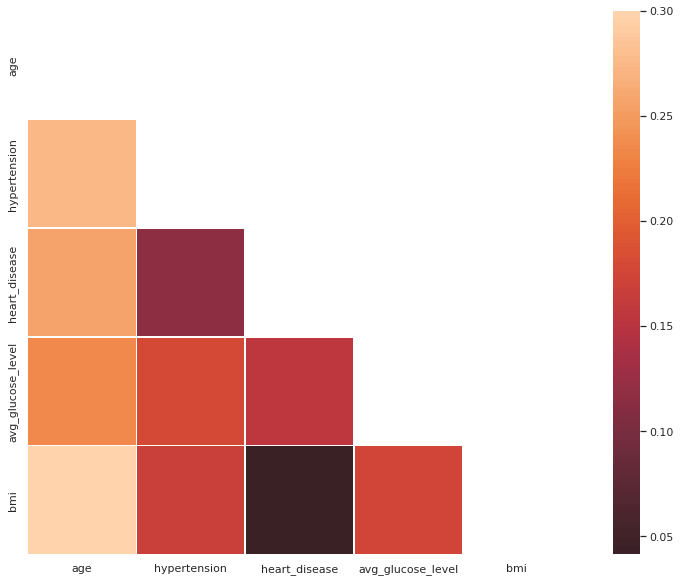

In [ ]:
sns.set_theme(style="white")
mask = np.triu(np.ones_like(df.drop(['id', 'stroke'], axis =1 ).corr(), dtype=bool)) #This is to get the diagonal so we don't see the same data twice
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.drop(['id', 'stroke'], axis =1 ).corr(), mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5)
plt.show()

# Graphing Age with respect to other columns
From the correlation matrix, we want to see how age compares to the other variables in terms of how likely they are to develop each of the other parameters. (bmi, average_glucose_level, heart_disease, hypertension).

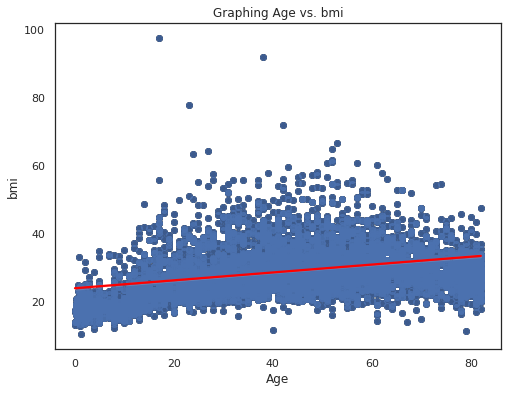

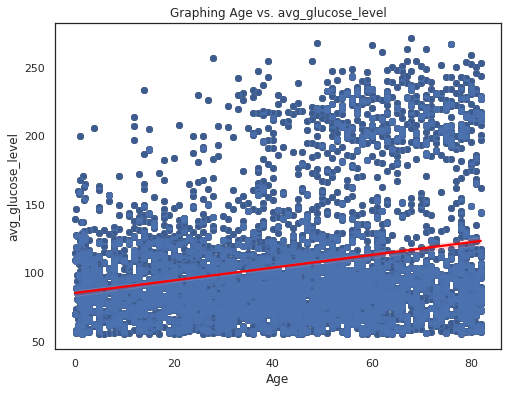

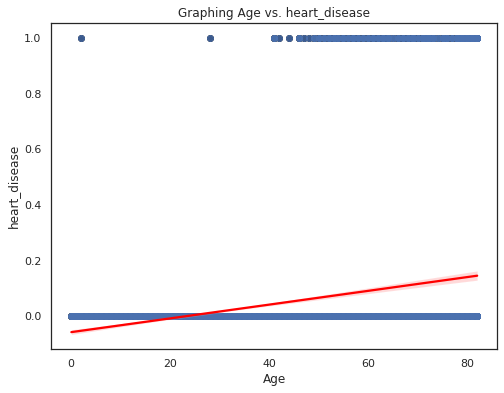

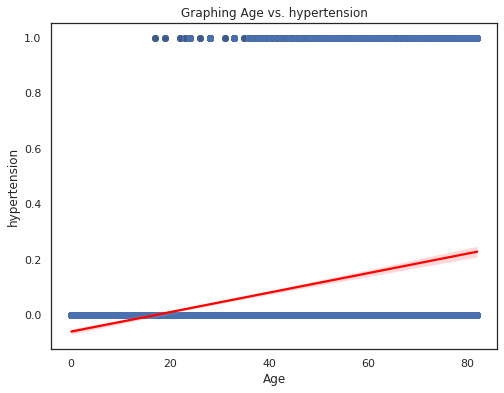

In [ ]:
age = df['age']
params =  ['bmi', 'avg_glucose_level', 'heart_disease', 'hypertension']
temp_df = df.copy()
temp_df.drop('age', axis = 1)
for i in params:
  plt.figure(figsize=(8, 6))
  plt.scatter(age, temp_df[i], color = 'black')
  sns.regplot(x=age, y=i, data = temp_df, line_kws={"color": "red"})
  plt.xlabel('Age')
  plt.ylabel(f"{i}")
  plt.title(f"Graphing Age vs. {i}")
  plt.show()
  print("\n\n")

# What can we understand from these Graphs?

First and foremost, without the lines of best fit, we can understand that there is a positive correlation between age and bmi and age and average glucose level. We can look at the graphs for that and even though the graphical readout is densely packed, we can understand the correlation. However when we come to the binary data where we dont really see individual data points or trends at all, we find it useful to plot a linear regression line using [seaborn](https://seaborn.pydata.org/). When we look at the data for age vs. heart disease and age vs. hypertension, we see a very positive correlation between the two, because we have a linear regression line with a definite positive slope, which helps us interpret the data a lot better.
## Why not graph Age versus the other variables in the dataframe?
 
Well this would be hard because all of the data in the other columns is categorial, so even though we assigned a numerical value to it with respect to a dictionary, we cannot graph linear regression based on categorical variables. 

The following plots are generated using some basic [Pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html) functions which might help us distill some information about the relationship between variables.
A hexbin might be hard to interpret, considering its infrequent use. For more information, go to [this link](https://www.python-graph-gallery.com/84-hexbin-plot-with-matplotlib).

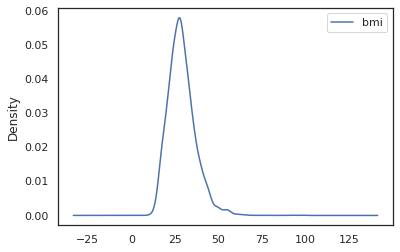

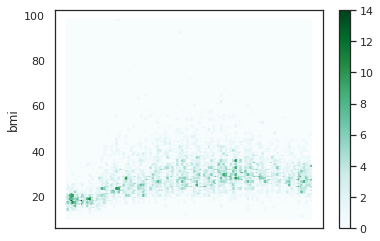

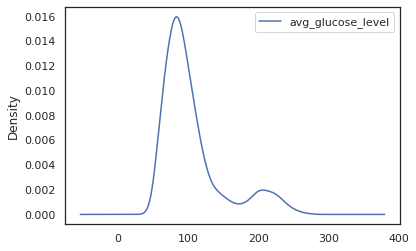

In [ ]:
df.plot(kind = 'density', x = 'age', y = 'bmi')
df.plot(kind = 'hexbin', x = 'age', y = 'bmi')
df.plot(kind = 'density', x = 'bmi', y = 'avg_glucose_level')

# Modeling our data


We first started with a unique Confusion matrix and classification report with labels. This was to get an idea of the false positvies and false negatives as they pertain to the data. 

In [ ]:
def confusion_mtrx(actual, prediction):
    # if not isinstance(actual, np.ndarray):
    #     print(type(actual))
    #     prediction = tf.make_ndarray(prediction)
    #     actual = tf.make_ndarray(actual)
    # View results as a confusion matrix to visualize our performance metrics
    cm = confusion_matrix(actual, prediction)
    cm = np.array(confusion_matrix(actual, prediction, labels=[1,0]))
    confusion_tree = pd.DataFrame(cm, index=['stroke', 'no_stroke'],
                            columns=['predicted_stroke','predicted_no_stroke'])
    print('Confusion matrix for model: \n', confusion_tree)
    print('Classification report: \n', classification_report(actual, prediction))

Although we were able to determine correlations using the correlation heatmap plot, we decided that it might be best to train on ALL features because we would rather not risk losing any information/paramaters. 

In [ ]:
print("Features: ", list(encoded_data.keys()))
data = np.asarray(encoded_data.drop(['stroke'], axis = 1))
print(np.shape(data))
X_train, X_test, Y_train, Y_test = train_test_split(data, encoded_data['stroke'], test_size = 0.3, random_state = 78)
X_train, X_test, Y_train, Y_test = X_train.astype(np.float), X_test.astype(np.float), Y_train.astype(np.float), Y_test.astype(np.float)


Features:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
(4909, 10)


The biggest issue we faced was the implicit bias of our dataset. As we see below, there are 137 positives and 3436 negative classifications in our training dataset, or about a 1 to 25 bias. The concern with this is that any models we use would undervalue/underestimate the importance of information gained from those datapoints. After conducting some research, we found that there are two significant ways by which data scientists navigate this issue: oversampling and class weights. Generally, class weights is the preferred approach; however, after attempting both we discovered that for some unknown reason to the TA's and us, class weights seemed to have no impact. As a result, we decided to [oversample the positive classification](https://towardsdatascience.com/how-to-fix-feature-bias-9e47abccb942
) datapoints in our dataset, as seen below. After oversampling, we achieve around a 1 to 1 ratio (50% positive and negatives)



In [ ]:
oversample = list([i for i,j in zip(X_train,Y_train) if j == 1])
print("Positives vs Negatives before Oversampling: ", len(oversample), len(Y_train) - len(oversample))
X_train = np.array(list(X_train) + (15 * oversample))
Y_train = np.array(list(Y_train) + (15*len(oversample) * [1]))
print("Positives vs Negatives after Oversampling: ", 15*len(oversample), 15*(len(Y_train)- len(oversample)))

Positives vs Negatives before Oversampling:  137 3299
Positives vs Negatives after Oversampling:  2055 80310


# Decision Tree

The code below builds a single decision tree classifier. We feed it the same oversampled X_Train and Y_train data from our initial split and evaluate using our original x_test and y_test. As we mentioned above, because our data has so much bias, we do not expect to see great results with this. Our main metric for efficacy was the overall F1-Score along with the F1 score for the true (1) classification. F1-score close to 1 is good vs 1 close to 0 is bad. As we see below, the model is very good at predicting negatives; however, is not very good at predicting the positives. This could mean that the model is mainly predicting 0's as the output. In addition, we notice that the model is very good at predicting true negatives.

In [ ]:
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, Y_train)
y_predict_tree = tree_model.predict(X_test)
confusion_mtrx(np.array(Y_test), np.array(y_predict_tree))
fig = plt.figure(figsize=(30,20))
 _ = tree.plot_tree(tree_model, 
                   feature_names=df.columns,  
                    class_names='stroke')

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   10                   62
no_stroke                51                 1350
Classification report: 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      1401
         1.0       0.16      0.14      0.15        72

    accuracy                           0.92      1473
   macro avg       0.56      0.55      0.56      1473
weighted avg       0.92      0.92      0.92      1473



<Figure size 2160x1440 with 0 Axes>

Now that we have visualized our decision tree, we can look towards the top of the tree and determine the most important 
features. The top three features seem to be bmi, age, and average glucose level. Now that we know this information, we can create 
pairplots and try to find relationships between these important features.

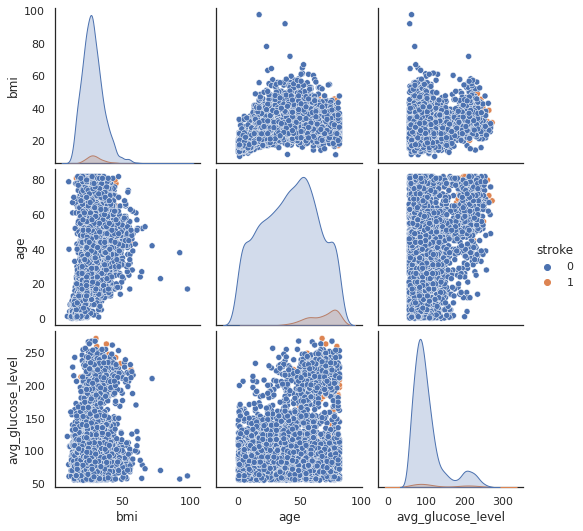

In [ ]:
sns.pairplot(df, hue = 'stroke', vars = ['bmi', 'age', 'avg_glucose_level'] )

These pairplots do not give us much insight. This is because our dataset does not have many
people who suffered strokes in it. To better understsand how important each feature is, we can
use Singular Value Decomposition and extract the three most important, or principal, features of the data. SVD actually allows us to decompose the data within a matrix, then reconstruct it such that the dimension of that data is reduced. This is useful to us because it is hard to visualize more than 3 variables within a plot. Since we are 3 dimensional beings, 3 dimensional plots are, as expected, much easier to create and to interpret. SVD also tells us that the three most important features make up a signifigant majority of variance within the data. Singular values relate directly to dimensional variance. The 3d plot below contains our data projected onto 3d space, where the axes are only Age, BMI, and glucose level. Intuivitely, it might be easy to tell that those factors are the best indicators of risk of stroke. However, the plot offers more insight than that. It is clear by looking at the visible clustering that our stroke candidates most likely are contained within the area with high BMI, age, and glucose level.

Considering this, a simple ellipsoid encapsulating that area in the space might serve as a better indicator of stroke risk. Perhaps distance from the center of such a shape could be used as an measure of risk of stroke.

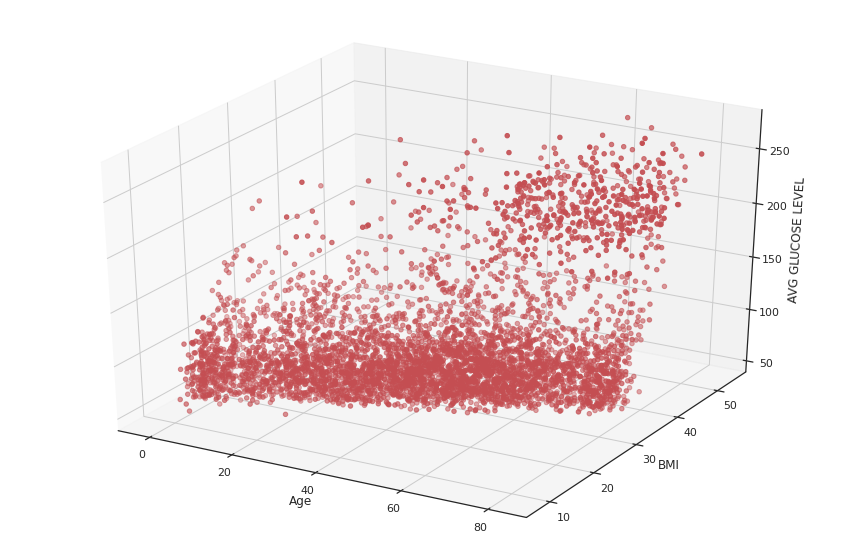

id    gender        age  ...        bmi  smoking_status    stroke
0   9045.999316  0.737559  65.791160  ...  41.145730        1.528508  0.107868
1  31111.999491  0.690428  79.079393  ...  35.924198        1.085317  0.101743
2  60181.999432  0.768813  47.985903  ...  38.270064        1.736693  0.050604
3   1664.998043  0.661838  75.486482  ...  37.233334        1.141057  0.119356
4  56668.997396  0.914699  76.303498  ...  46.629170        1.822165  0.092379

[5 rows x 12 columns]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

tmp1 = np.array(df.to_numpy(), dtype=np.float)
U, S, V = np.linalg.svd(tmp1)
tmp1new = U[:, :3] @ np.diag(S[:3]) @ V[:3, :]
tmp1newdf = pd.DataFrame(tmp1new, columns=df.columns)

x = np.array(tmp1newdf.age)
y = np.array(tmp1newdf.bmi)
z = np.array(tmp1newdf.avg_glucose_level)

ax.set_xlabel('Age')
ax.set_ylabel('BMI')
ax.set_zlabel('AVG GLUCOSE LEVEL')

ax.scatter(x, y, z, c='r', marker='o')

plt.show()
tmp1newdf.head()


The reconstructed dataframe above from the three most important singular values from the SVD matrix has age, avg_glucose_level, and bmi values near identical to the values in the original dataframe. This further confirms that these seem to be the most important features when it comes to predicting stroke. They have the most variance in their dimensions in general, so it makes sense that the decision tree used these features as the most important ones. 

# Random Forest 

After seeing how low the F1 scores were for the positive classification using a single decision tree, we figured that a random forest may be better and modeling the abnormal data. 

The code below builds a random forest classifier. Once again, we feed it the same oversampled X_Train and Y_train data from our initial split and evaluate using our original x_test and y_test. As we mentioned above, because our data has so much bias, we do not expect to see great results with this. To our surprise, this model performed worse on average than the single decision tree, as seen by the low F1-score for the positive (1.0) classification. Once again, we notice that the model is very good at predicting true negatives. Likely the model is predicting all 0's.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = y_pred = [1 if i > 0.5 else 0 for i in y_predict_forest]
confusion_mtrx(np.array(Y_test), np.array(y_predict_forest))

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                    4                   68
no_stroke                11                 1390
Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1401
         1.0       0.27      0.06      0.09        72

    accuracy                           0.95      1473
   macro avg       0.61      0.52      0.53      1473
weighted avg       0.92      0.95      0.93      1473



decisio

In [ ]:
from xgboost import XGBRFClassifier
rf = XGBRFClassifier(n_estimators=100, use_label_encoder=False, verbose = True)
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]

confusion_mtrx(np.array(Y_test), np.array(y_predict_forest))

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   59                   13
no_stroke               299                 1102
Classification report: 
               precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      1401
         1.0       0.16      0.82      0.27        72

    accuracy                           0.79      1473
   macro avg       0.58      0.80      0.58      1473
weighted avg       0.95      0.79      0.85      1473



# Random Forest with Ada Boosting

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
rf = AdaBoostClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, Y_train)
y_predict_forest = rf.predict(X_test)
y_predict_forest = [1 if i > 0.5 else 0 for i in y_predict_forest]
confusion_mtrx(np.array(Y_test), np.array(y_predict_forest))


Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   44                   28
no_stroke               262                 1139
Classification report: 
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.89      1401
         1.0       0.14      0.61      0.23        72

    accuracy                           0.80      1473
   macro avg       0.56      0.71      0.56      1473
weighted avg       0.94      0.80      0.86      1473



# KNN classifier
Our next idea was to try and use a KNN classifier. We did not expect much out of this algorithm as it would pretty much be unaffected by the oversampling (as the same positive classification would show up and obviously get classified the same as the previous). As a result, we predicted that the model would be affected by the bias of the dataset and the results would be on par with the decision tree. Instead, we found that it was somewhat more affective and predicting the positive classifications.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=100) # tuned to 100
knn.fit(X_train, Y_train)
y_predict_knn = knn.predict(X_test)
y_predict_knn = [1 if i > 0.5 else 0 for i in y_predict_knn]
confusion_mtrx(np.array(Y_test), np.array(y_predict_knn))

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   34                   38
no_stroke               195                 1206
Classification report: 
               precision    recall  f1-score   support

         0.0       0.97      0.86      0.91      1401
         1.0       0.15      0.47      0.23        72

    accuracy                           0.84      1473
   macro avg       0.56      0.67      0.57      1473
weighted avg       0.93      0.84      0.88      1473



# Perceptron ANN
Our final attempt was much more heavy duty. We attempted to build a multilayer perceptron (MLP). This is just a fancy term for a fully connected network. We decided to mainly focus on metrix available in a confusion matrix, as from our experience, the loss and accuracy here arent a very good indicator of the neural network's efficacy.

Our neural network's architecture is as follows:

(input, dropout, activation, output)

1.   (10, 0.3, gelu, 32)
2.   (32, 0.3, gelu, 64)
3.   (64, 0.5, gelu, 128)
4.   (128,0.3, gelu, 64)
5.   (64, 0.1, gelu, 32)
6.   (32, 0.0, sigmoid, 1)

As you can see above, our first layer's input is 10 (for the number of features we are training on). We then scale up the number of nodes for the hidden layers in powers of, reaching a maximum of 128 nodes.

We also use a somewhat new activation function know as [gelu](https://arxiv.org/pdf/1606.08415.pdf) or Gaussian error linear unit. We chose gelu over relu or leaky relu because lots of modern research and models use them. As we understand it, gelu is meant to try to emulate relu and dropout in a deterministic way, so that an input x will always give the same output y. Moreover, the probability of dropout is supposedly higher when using gelu, so it theoretically should help with any overfitting. ![Image](./image.jpg)

In addition, we decided to also include some dropouts in order to combat overfitting later in training. Finally our last layer with a dense of 1 and a sigmoid [activation function](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#elu) is needed to consolidate our outputs to a single probability. We chose sigmoid becuase we are working with a binary classification, although we could also theoretically work with softmax.

The optimizer that we use is SGD or stochastic gradient descent. In general, sgd is pretty effective with CNN and simple MLP models, so we decided to give it and the adam optimizer a try. We found that [sgd](https://scikit-learn.org/stable/modules/sgd.html) was more effective than adam. 
We also looked into initializing [sgd with a momentum]( https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) of ~0.9 but found that it gave us worse results.
Finally, we initalized sgd with a learning rate of 1e-3 after some tinkering.

We compiled our model using binary cross entropy as our loss function. We did also play around with [SigmoidFocalCrossEntropy](https://www.tensorflow.org/addons/api_docs/python/tfa/losses/SigmoidFocalCrossEntropy) as it is supposedly effective on imbalanced datasets like ours, but we found that the results were worse. 


Once again, we attemped using class weights instead of oversampling and found that we had worse results.

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import tensorflow_addons as tfa

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve,
]

def create_model(idim = len(encoded_data.keys())-1):
  model = Sequential()

  model.add(Dense(32, input_dim=idim))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(64, input_dim=32))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))

  model.add(Dense(128, input_dim=64))
  model.add(Dropout(.5))
  model.add(Activation('gelu'))

  model.add(Dense(64, input_dim=128))
  model.add(Dropout(.3))
  model.add(Activation('gelu'))
  
  model.add(Dense(32, input_dim=64))
  model.add(Dropout(.1))
  model.add(Activation('gelu'))

  model.add(Dense(1, input_dim=32))
  model.add(Activation('sigmoid'))

  optimizer = tf.keras.optimizers.SGD(
    learning_rate=1e-3, nesterov=False,
  )
  #tfa.losses.SigmoidFocalCrossEntropy()
  model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(),  metrics=METRICS)
  return model

'''This code is commented out as to show one of our attempts that wasn't as good as it could have been, but is still important to our developmental process'''
# class_weight = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = np.array(df.stroke))
# class_weight = {0: class_weight[0],
#                 1: class_weight[1]}
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 activation_6 (Activation)   (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 activation_7 (Activation)   (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)              

Our fit function call runs for 50 epochs and takes in 3 callback functions: 


*   Checkpoint weight saving
*   Early stopping
*   Reduce learning rate on plateau
 



In [ ]:
history = model.fit(x=X_train.astype(np.float), y=Y_train.astype(np.float), batch_size=8, epochs=50, validation_data=(X_test, Y_test), verbose=1, shuffle=True, callbacks=
                                [ModelCheckpoint(filepath='./ckpts/best_val_loss.hdf5',
                                               monitor= 'val_loss',
                                               save_best_only=True,
                                               mode='auto',
                                               save_weights_only=True,
                                               verbose=2),
                                EarlyStopping(monitor='val_loss',
                                             mode='auto',
                                             patience=100,
                                             verbose=1),  
                                ReduceLROnPlateau(
                                monitor='loss', factor=0.1, patience=10, verbose=1,
                                mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
                            )])

Epoch 1/50
679/687 [============================>.] - ETA: 0s - loss: 0.6509 - tp: 5.0000 - fp: 1.0000 - tn: 3261.0000 - fn: 2165.0000 - accuracy: 0.6013 - precision: 0.8333 - recall: 0.0023 - auc: 0.6257 - prc: 0.5016
Epoch 00001: val_loss improved from inf to 0.52245, saving model to ./ckpts/best_val_loss.hdf5
687/687 [==============================] - 3s 4ms/step - loss: 0.6506 - tp: 5.0000 - fp: 1.0000 - tn: 3298.0000 - fn: 2187.0000 - accuracy: 0.6015 - precision: 0.8333 - recall: 0.0023 - auc: 0.6259 - prc: 0.5004 - val_loss: 0.5224 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1401.0000 - val_fn: 72.0000 - val_accuracy: 0.9511 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6952 - val_prc: 0.1229 - lr: 0.0010
Epoch 2/50
677/687 [============================>.] - ETA: 0s - loss: 0.6478 - tp: 3.0000 - fp: 3.0000 - tn: 3252.0000 - fn: 2158.0000 - accuracy: 0.6010 - precision: 0.5000 - recall: 0.0014 - auc: 0.6324 - prc: 0.5024
Epoch 00002: val_loss did not i

As we see below, the validation loss and accuracy seem somewhat trace its training counterparts; however, like I mentioned before, these arent great indicators for our dataset because of the extreme bias. What we are really interested in is the confusion matrix and the F1 scores. As we see, similar to our other models, the neural net is very good at predicting true negatives but not great at predicting true positives. We do however see that in general, the neural net outperforms every other model in terms of its F1-score for the positive classifications (1.0). The highest F1-score we were able to acheive for the positive classifications was 0.31.

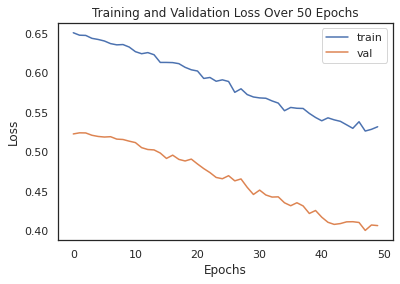

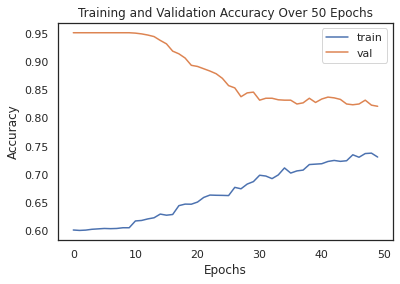

Confusion matrix for model: 
            predicted_stroke  predicted_no_stroke
stroke                   48                  224
no_stroke                24                 1177
Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.98      0.90      1201
           1       0.67      0.18      0.28       272

    accuracy                           0.83      1473
   macro avg       0.75      0.58      0.59      1473
weighted avg       0.81      0.83      0.79      1473



In [ ]:
history.history['loss']
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Loss")
pyplot.title("Training and Validation Loss Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()

history.history['accuracy']
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='val')
pyplot.xlabel("Epochs")
pyplot.ylabel("Accuracy")
pyplot.title("Training and Validation Accuracy Over %d Epochs" % (len(history.history['loss']),))
pyplot.legend()
pyplot.show()
 
from sklearn.metrics import log_loss # The data is binary
from math import sqrt

model.built = True
model.load_weights("ckpts/best_val_loss.hdf5")
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred] # roc curve when you change threshold
confusion_mtrx(y_pred, Y_test)

# Conclusion 
We have gone through a standard Data Science pipeline. We identified our variable of interest, strokes, and utilized machine learning models to understand what factors most affect one's likelihood of having one and to predict whether an individual will suffer one based off some identifying features used in our dataset we gathered. We have learned through this process that BMI, average glucose level, and age are the most significant factors that contribute to suffering a stroke. We demonstrated how several machine learning models can be used to predict stroke and that the model that is most appropriate for a given research organization will depend on what tradeoffs they are willing to take. For example, they may value predicting true positives more than predicting true negatives, in which case the Perceptron ANN might be most appropriate. We also noted that a reliable machine learning model would need to somehow address the problem of predicting true positives with the same accuracy as true negatives. This problem had much to do with the specifics of our dataset, but the simple fact that most people do not suffer strokes makes this a difficult problem to solve when training a model. Nonetheless, the process we demonstrated is only the first step when it comes to understanding exactly how strokes work and how they can be prevented, but it is an important first step that can be used to guide further research decisions. For more information about strokes and how they can be prevented, visit this [website](https://www.cdc.gov/stroke/healthy_living.htm).